In [4]:
import pandas as pd
import nltk
import json
import gensim
import tqdm

### Get text and load as a DataFrame

In [5]:
## Get text and load as a DataFrame

nltk.download('punkt')

def read_book_to_dataframe(file_path):
    # Read the text file
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    # Split the text into sentences
    sentences = nltk.tokenize.sent_tokenize(text)

    # Create a DataFrame
    df = pd.DataFrame(sentences, columns=['Sentence'])

    return df

# Using the .txt file that's in the same directory
file_path = 'anna_karenina.txt'
df = read_book_to_dataframe(file_path)

df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/evanwineland/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Sentence
0,PART ONE\nChapter 1\nHappy families are all al...
1,Everything was in confusion in the Oblonskys’ ...
2,The wife had discovered that the husband was c...
3,This position of affairs had now lasted three ...
4,Every person in the house felt that there was ...


In [6]:
## Note: install spacy at the command line first.  Then, download en_core_web_sim
import re
import bs4
import requests
import spacy
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 

# nlp = spacy.load("en_core_web_sm")

pd.set_option('display.max_colwidth', 200)

In [7]:
nlp = spacy.load("en_core_web_sm")

In [8]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # only analyze if the current token isn't punctuation
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [9]:
df.shape[0], df.head()

(16807,
                                                                                                                                                                                                   Sentence
 0                                                                                                       PART ONE\nChapter 1\nHappy families are all alike; every unhappy family is unhappy in its own way.
 1                                                                                                                                                     Everything was in confusion in the Oblonskys’ house.
 2  The wife had discovered that the husband was carrying on an intrigue with a French girl, who had been a governess in their family, and she had announced to her husband that she could not go on liv...
 3                     This position of affairs had now lasted three days, and not only the husband and wife themselves, but all the members of their family and household, were

In [10]:
get_entities(df['Sentence'][0])

['unhappy  family', 'own  way']

In [11]:
e_pairs = []

for i in tqdm(df["Sentence"]):
    e_pairs.append(get_entities(i))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16807/16807 [01:34<00:00, 178.42it/s]


In [12]:
e_pairs[0:10]

[['unhappy  family', 'own  way'],
 ['Everything', 'Oblonskys  house'],
 ['she', 'same  him'],
 ['only  husband', 'painfully  it'],
 ['stray  people', 'common  Oblonskys'],
 ['own  husband', 'three  days'],
 ['just kitchen coachman', 'warning'],
 ['days Stepan Arkadyevitch he', 'covered  study'],
 ['once  he', 'eyes'],
 ['now  he', 'dream']]

In [13]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern]) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [14]:
get_relation("Kaan finished the race.")

'finished'

In [20]:
relations = [get_relation(i) for i in df["Sentence"]]
relations[:50]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16807/16807 [01:36<00:00, 173.44it/s]


['is unhappy',
 'was in',
 'discovered',
 'lasted',
 'felt',
 'been at',
 'walked off',
 'woke',
 'embraced',
 'thought',
 'was',
 'be sure',
 'giving',
 'was in',
 'remembered',
 'twinkled',
 'was nice',
 'dropped',
 'stretched',
 'remembered',
 'Ah',
 'muttered',
 'was present',
 'forgive',
 'is',
 'reflected',
 'kept',
 'was',
 'fussing',
 '’s',
 'this',
 'was',
 'happened to',
 'succeed in',
 'reflected',
 'smile',
 'shuddered',
 'refused',
 'thought',
 '’s',
 'said to',
 'was',
 'was incapable',
 'at',
 'was',
 'felt',
 'managed',
 'thought',
 'supposed',
 'turned']

### Create and visualize the KG using entities and relationships

In [17]:
source = [i[0] for i in e_pairs]
target = [i[1] for i in e_pairs]

In [18]:
kg_df = pd.DataFrame({'source': source, 'target': target, 'relation': relations})
kg_df.head()

,source,target,relation
0,unhappy family,own way,is unhappy
1,Everything,Oblonskys house,was in
2,she,same him,discovered
3,only husband,painfully it,lasted
4,stray people,common Oblonskys,felt


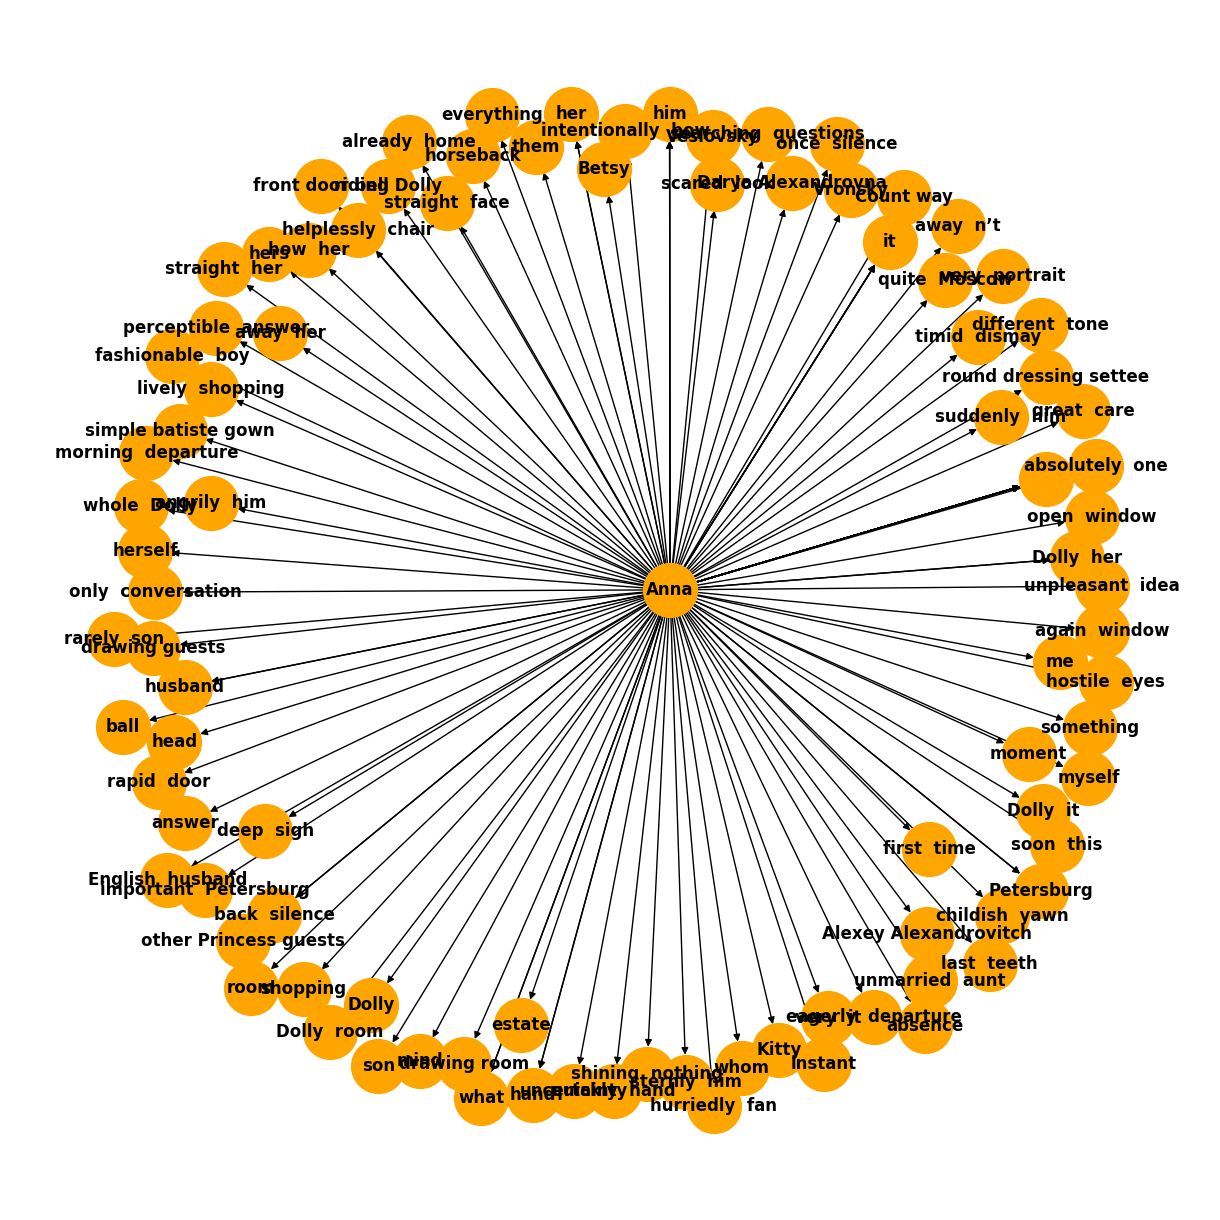

In [35]:
graph = nx.from_pandas_edgelist(kg_df[kg_df['source']=="Anna"], "source", "target", edge_attr = True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(graph, k = .5)
nx.draw(graph, with_labels=True, node_color = 'orange', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight = 'bold')

plt.show()

Getting edge labels required I compromise on having a directed graph with multiple edges between nodes.

I also want to limit the number of these that I have.

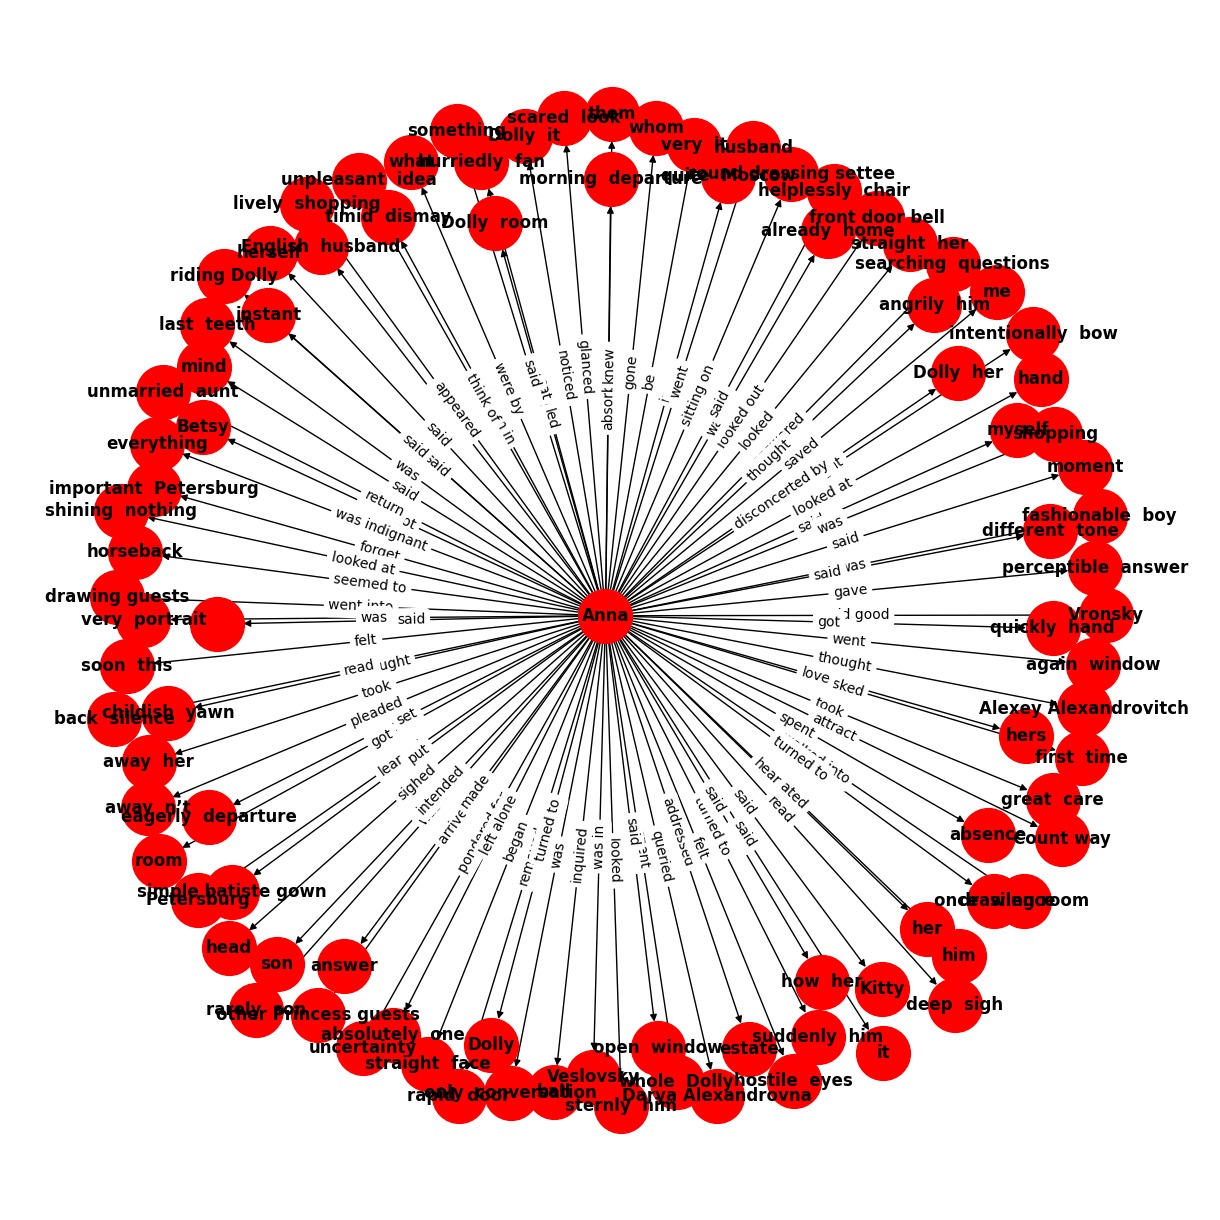

In [43]:
## Make the graph, but with labeled edges
graph = nx.from_pandas_edgelist(kg_df[kg_df['source']=="Anna"], "source", "target", edge_attr = True, create_using=nx.DiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(graph, k = .5)
nx.draw(graph, with_labels=True, node_color = 'red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight = 'bold')

#Draw labels
edge_labels = nx.get_edge_attributes(graph, 'relation')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

plt.show()